# Instructions for running the code:

### Requirements:

You will need to install the following modules by running the command in your terminal

(Make sure pip is installed beforehand)

```pip install pandas numpy scipy matplotlib seaborn statsmodel.api```

Download the data spreadsheet from below and follow the instructions in the next section
https://docs.google.com/spreadsheets/d/1OMUGC0Lsc9Wcz0meNc60cYueFgQHgk7y/edit?usp=sharing&ouid=116454902044879445309&rtpof=true&sd=true

### Directory structure:
You should have a folder structured like this to run the code:
```
-Folder 
|
--EC1B1_code.ipynb
|
--IFS.xlsx
|
--Final_OneSheet_Cleaned.xlsx <- [generated by the code in Section 4]
```

# Code for Section 4

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

###############################################################################
# STEP 1) READ EXCEL FILES (TWO SEPARATE SHEETS)
###############################################################################

# Set the file path to the Excel spreadsheet.
file_path = 'IFS.xlsx'

# Read Italy's data (adjust header row if necessary)
italy_df = pd.read_excel(file_path, sheet_name='IFS ITALY', header=2)

# Read US' data
us_df = pd.read_excel(file_path, sheet_name='IFS USA', header=2)

# Strip spaces from column names to avoid mismatches
italy_df.columns = italy_df.columns.str.strip()
us_df.columns = us_df.columns.str.strip()

###############################################################################
# STEP 2) RENAME COLUMNS
###############################################################################
# We rename the original long column headers to concise, clear names.
# For example, if the Italy sheet has:
#   Date
#   Economic Activity, Industrial Production, Index
#   Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate
#   International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar
#   Prices, Consumer Price Index, All items, Index
# Similarly, for the US sheet we rename:
#   Date
#   International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar
#   Prices, Consumer Price Index, All items, Index
###############################################################################
italy_df.rename(columns={
    "Date": "Date",
    "Economic Activity, Industrial Production, Index": "Industrial Production",
    "Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate": "Exchange Rate",
    "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar": "International Reserves",
    "Prices, Consumer Price Index, All items, Index": "Consumer Prices"
}, inplace=True)

us_df.rename(columns={
    "Date": "Date",
    "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar": "US International Reserves",
    "Prices, Consumer Price Index, All items, Index": "US Consumer Prices"
}, inplace=True)

###############################################################################
# STEP 3) MERGE THE TWO SHEETS INTO A SINGLE DATAFRAME
###############################################################################
# Merge on the date String.
# We use an inner merge to keep only matching "Date" rows.
# If 1959 is missing, it means it wasn't matched or wasn't present in one sheet.
###############################################################################
merged_df = pd.merge(italy_df, us_df, on='Date', how='inner')

merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%b %Y')  # Example: "Jan 1960"
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y-%m')
merged_df = merged_df.sort_values(by='Date')  # Ensure chronological order

print("Merged rows:", len(merged_df))

###############################################################################
# STEP 4) ENSURE NUMERIC COLUMNS
###############################################################################
# We want to perform numeric operations (e.g., .pct_change(), * multiplications),
# so convert these columns to float. If there's text or blanks, they become NaN.
###############################################################################
numeric_cols = [
    "Exchange Rate",
    "Consumer Prices",
    "Industrial Production",
    "International Reserves",
    "US Consumer Prices",
    "US International Reserves"
]
for col in numeric_cols:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

###############################################################################
# STEP 5) CALCULATE ITALY'S VARIABLES
###############################################################################
# Explanation of each variable:
#
# (i) nominal_exchange_growth:
#     This is the month-to-month percentage change in the nominal exchange rate
#     (Exchange Rate = "Euro per US dollar"). We use .pct_change()
#     which calculates (current - previous) / previous.
###############################################################################
merged_df['nominal_exchange_growth'] = merged_df['Exchange Rate'].pct_change()

###############################################################################
# (ii) real_exchange_rate:
#      Real Exchange Rate (RER) is typically defined as:
#         RER = (nominal exchange rate) * (foreign price level / domestic price level)
#      Here, "foreign" is the US, "domestic" is Italy. So:
#         real_exchange_rate = ExchangeRate * (USConsumerPrices / ItalyConsumerPrices)
#
# (ii-b) real_exchange_growth:
# Monthly growth rate in the real exchange rate.
# Formula: (Real Exchange Rate_t - Real Exchange Rate_(t-1)) / Real Exchange Rate_(t-1)

###############################################################################
merged_df['real_exchange_rate'] = (
        merged_df['Exchange Rate'] *
        (merged_df['US Consumer Prices'] / merged_df['Consumer Prices'])
)
merged_df['real_exchange_growth'] = merged_df['real_exchange_rate'].pct_change()

###############################################################################
# (iii) real_exchange_index:
#       We set the real exchange rate of "Dec 1990" = 1. If "Dec 1990" isn't found,
#       we fallback to the last row in the dataset. Then we scale the real_exchange_rate
#       by dividing all RER values by the reference one.
###############################################################################
dec_1990_row = merged_df.loc[merged_df['Date'] == "1990-12"]
if not dec_1990_row.empty:
    dec_1990_value = dec_1990_row['real_exchange_rate'].iloc[0]
else:
    dec_1990_value = merged_df['real_exchange_rate'].iloc[-1]  # fallback: last row
merged_df['real_exchange_index'] = merged_df['real_exchange_rate'] / dec_1990_value

###############################################################################
# (iv) inflation_rate (Italy):
#      The month-to-month percentage change in Italy's Consumer Prices:
###############################################################################
merged_df['inflation_rate'] = merged_df['Consumer Prices'].pct_change()

###############################################################################
# (v) industrial_production_growth (Italy):
#     The month-to-month percentage change in industrial production:
###############################################################################
merged_df['industrial_production_growth'] = merged_df['Industrial Production'].pct_change()

###############################################################################
# (vi) industrial_production_12m_growth (Italy):
#      The growth relative to 12 months ago. If the data is monthly,
#      .pct_change(periods=12) compares current vs. 12 rows prior:
###############################################################################
merged_df['industrial_production_12m_growth'] = merged_df['Industrial Production'].pct_change(periods=12)

###############################################################################
# (vii) Italy's reserves_index (January 1960 = 100):
#       We locate "Jan 1960" in the Date column. If found, we take that row's
#       "International Reserves" as the base. If not found, fallback to the
#       first row. Then we scale all Italy reserves so that the reference = 100.
###############################################################################
jan_1960_row_italy = merged_df.loc[merged_df['Date'] == "Jan 1960"]
if not jan_1960_row_italy.empty:
    italy_base_res = jan_1960_row_italy['International Reserves'].iloc[0]
else:
    italy_base_res = merged_df['International Reserves'].iloc[0]
merged_df['reserves_index'] = (merged_df['International Reserves'] / italy_base_res) * 100

###############################################################################
# STEP 6) CALCULATE US VARIABLES
###############################################################################
# (i) us_inflation_rate:
#     The month-to-month % change in "US Consumer Prices"
###############################################################################
merged_df['us_inflation_rate'] = merged_df['US Consumer Prices'].pct_change()

###############################################################################
# (ii) us_reserves_index:
#      The index of "US International Reserves" with "Jan 1960" = 100.
#      If "Jan 1960" isn't in the data, fallback to the first row for the base.
###############################################################################
jan_1960_row_us = merged_df.loc[merged_df['Date'] == "Jan 1960"]
if not jan_1960_row_us.empty:
    us_base_res = jan_1960_row_us['US International Reserves'].iloc[0]
else:
    us_base_res = merged_df['US International Reserves'].iloc[0]
merged_df['us_reserves_index'] = (merged_df['US International Reserves'] / us_base_res) * 100

###############################################################################
# STEP 7) IDENTIFY & FLAG OUTLIERS
###############################################################################
# We define an outlier if its Z-score > 3 in absolute value.
# A z-score is (x - mean) / std, so if |z|>3, that data point is far from the mean
# relative to standard deviation. This is a simple approach to detect "implausibly
# extreme observations."
#
# We'll:
#   1) compute z-scores on each new variable ignoring NaN
#   2) print out each outlier's Date, value, and z-score
#   3) set that data point to NaN in the DataFrame
###############################################################################
analysis_cols = [
    'nominal_exchange_growth',
    'real_exchange_growth',
    'real_exchange_index',
    'inflation_rate',
    'industrial_production_growth',
    'industrial_production_12m_growth',
    'reserves_index',
    'us_inflation_rate',
    'us_reserves_index'
]

# We'll keep a mask of outliers for highlighting in Excel
outlier_mask = pd.DataFrame(False, index=merged_df.index, columns=analysis_cols)


def find_and_flag_outliers(df, cols):
    for col in cols:
        if col not in df.columns:
            continue
        # Drop NaNs before computing z-scores
        non_null_series = df[col].dropna()
        if non_null_series.empty:
            continue

        # The "stats.zscore" function returns an array of z-scores in the same order
        z_array = stats.zscore(non_null_series)
        # We convert that array to a Series for easier indexing
        z_series = pd.Series(data=np.abs(z_array), index=non_null_series.index)

        # Outlier points: z>4.5
        outlier_indices = z_series[z_series > 4.5].index
        if len(outlier_indices) > 0:
            print(f"\nOutliers detected in '{col}':")
            for idx in outlier_indices:
                row_date = df.loc[idx, 'Date']
                row_val = df.loc[idx, col]
                row_z = z_series.loc[idx]
                print(f"  Date={row_date}, {col}={row_val}, Z-score={row_z}")

            # Mark them as outliers in the mask & set them to NaN
            df.loc[outlier_indices, col] = np.nan
            outlier_mask.loc[outlier_indices, col] = True


# Call this function on merged_df
find_and_flag_outliers(merged_df, analysis_cols)

outlier_counts = outlier_mask.sum().sum()
if outlier_counts > 8:
    print(f"⚠️ Warning: {outlier_counts} outliers detected! Consider adjusting the threshold.")


###############################################################################
# STEP 8) INTERPOLATE MISSING DATA (INCLUDING OUTLIERS)
###############################################################################
# We use a linear interpolation method, which takes the average of the
# neighboring data points in each series. This includes the outliers we flagged
# (set to NaN), as well as any other missing points.
#
# We'll also create a mask "interp_mask" to highlight which cells were newly
# filled by interpolation (they were NaN before, but are not NaN after).
###############################################################################
before_interpolation = merged_df[analysis_cols].copy()
merged_df[analysis_cols] = merged_df[analysis_cols].interpolate(method='linear')
after_interpolation = merged_df[analysis_cols]

interp_mask = (before_interpolation.isna() & ~after_interpolation.isna())

###############################################################################
# STEP 9) SAVE THE FINAL SINGLE SHEET WITH HIGHLIGHTING FOR OUTLIERS & INTERPOLATION
###############################################################################
# We will color outlier cells in red, interpolated cells in yellow.
# All this is done in ONE final sheet named "Final Analysis".
###############################################################################
final_file = "Final_OneSheet_Cleaned.xlsx"
writer = pd.ExcelWriter(final_file, engine='xlsxwriter')

# Write the entire merged_df to one sheet
merged_df.to_excel(writer, sheet_name='Final Analysis', index=False)

# Access the workbook & worksheet to apply formats (outliers=red, interpolated=yellow)
workbook = writer.book
worksheet = writer.sheets['Final Analysis']

# Widen columns so the variable names won't be squashed
worksheet.set_column(0, len(merged_df.columns) - 1, 28)

# Create cell formats
outlier_format = workbook.add_format({'bg_color': '#FFC7CE'})  # Light Red
interp_format = workbook.add_format({'bg_color': '#FFEB9C'})  # Light Yellow

# Loop through each row/col to apply highlighting
for row_idx in range(len(merged_df)):
    for col_idx, col_name in enumerate(merged_df.columns):
        # We only highlight analysis_cols (the new computed columns)
        if col_name not in analysis_cols:
            continue

        excel_row = row_idx + 1  # +1 offset due to header row in to_excel
        excel_col = col_idx

        # If this cell was flagged as an outlier
        if col_name in outlier_mask.columns and outlier_mask.loc[row_idx, col_name]:
            cell_value = merged_df.loc[row_idx, col_name]
            worksheet.write(excel_row, excel_col, cell_value, outlier_format)
        # If this cell was newly interpolated
        elif col_name in interp_mask.columns and interp_mask.loc[row_idx, col_name]:
            cell_value = merged_df.loc[row_idx, col_name]
            worksheet.write(excel_row, excel_col, cell_value, interp_format)
        # Otherwise, leave the default formatting from to_excel

writer._save()


outliers_detected = outlier_mask.sum().sum()
interpolated_values = interp_mask.sum().sum()

print(f"\n🔎 Outlier Detection Summary:")
print(f"   - Total Outliers Flagged: {outliers_detected}")
print(f"   - Total Values Interpolated: {interpolated_values}")


print(f"\nAll done! Final results saved to '{final_file}' in one sheet ('Final Analysis').")

pd.options.display.max_rows = 385

print(merged_df)

pd.options.display.max_rows = 10

Merged rows: 372

Outliers detected in 'nominal_exchange_growth':
  Date=1976-02, nominal_exchange_growth=0.09272569419463528, Z-score=4.704112611770295

Outliers detected in 'industrial_production_growth':
  Date=1981-09, industrial_production_growth=1.53682588597843, Z-score=4.981112743681495
  Date=1982-09, industrial_production_growth=1.4805642633228855, Z-score=4.794172842398261
  Date=1986-09, industrial_production_growth=1.4456553755522847, Z-score=4.678181448518681
  Date=1987-09, industrial_production_growth=1.474127906976741, Z-score=4.772786828927969

🔎 Outlier Detection Summary:
   - Total Outliers Flagged: 5
   - Total Values Interpolated: 5

All done! Final results saved to 'Final_OneSheet_Cleaned.xlsx' in one sheet ('Final Analysis').
        Date  Industrial Production  Exchange Rate  International Reserves  \
0    1959-12              32.079105     621.118012             3119.500000   
1    1960-01              31.159146     621.118012             2989.500000   
2    1

# Code for Section 5.2

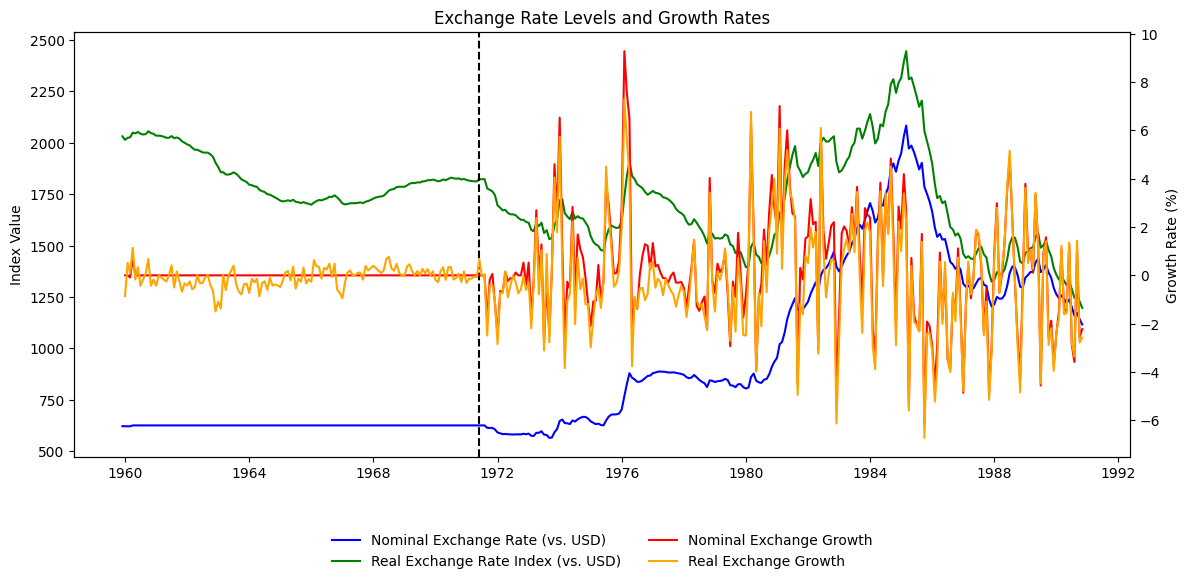

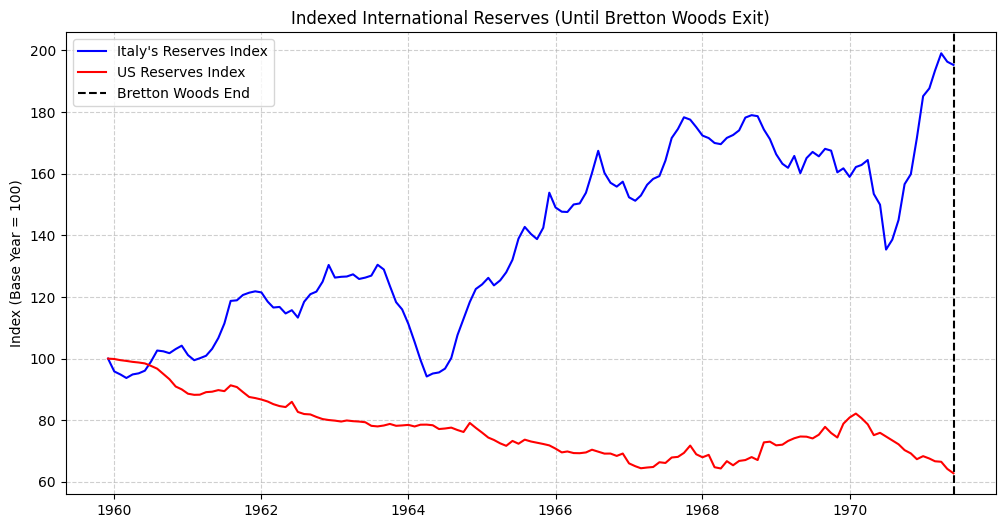

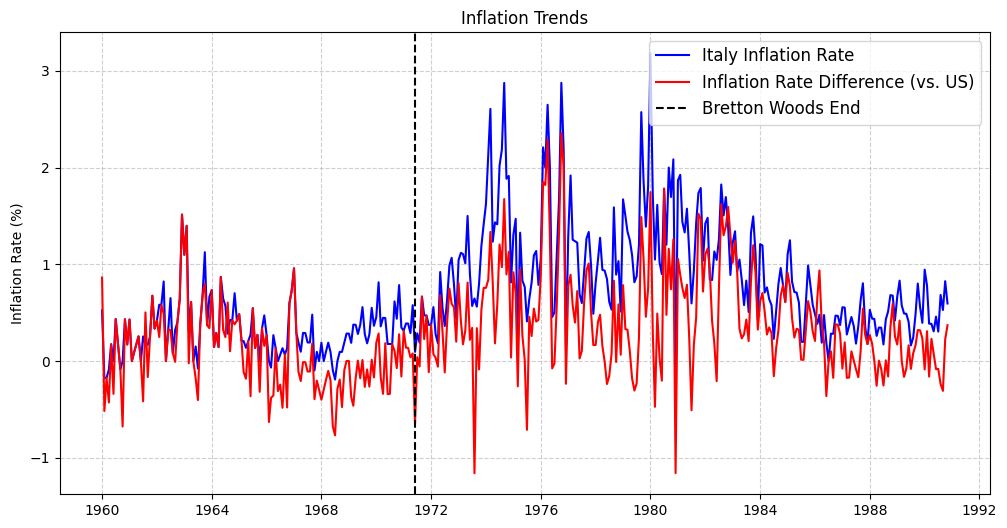

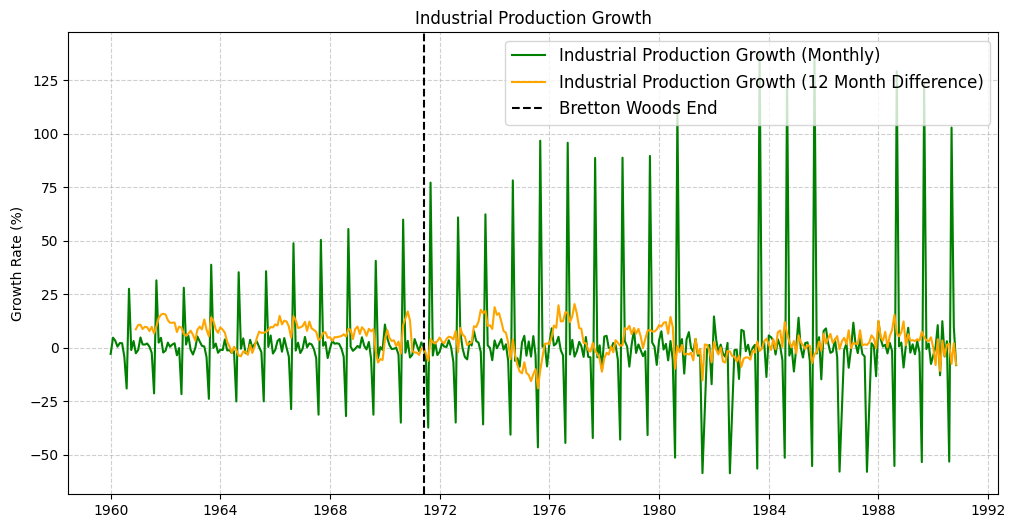

Standard Deviations Before and After Bretton Woods


,Pre-Bretton Woods,Post-Bretton Woods,Ratio (Post:Pre)
Nominal_Exchange_Growth,0.06,2.53,41.60
Real_Exchange_Growth,0.41,2.49,5.99
inflation_rate,0.29,0.60,2.07
Inflation_Difference,0.41,0.56,1.38
industrial_production_12m_growth,5.20,7.15,1.38


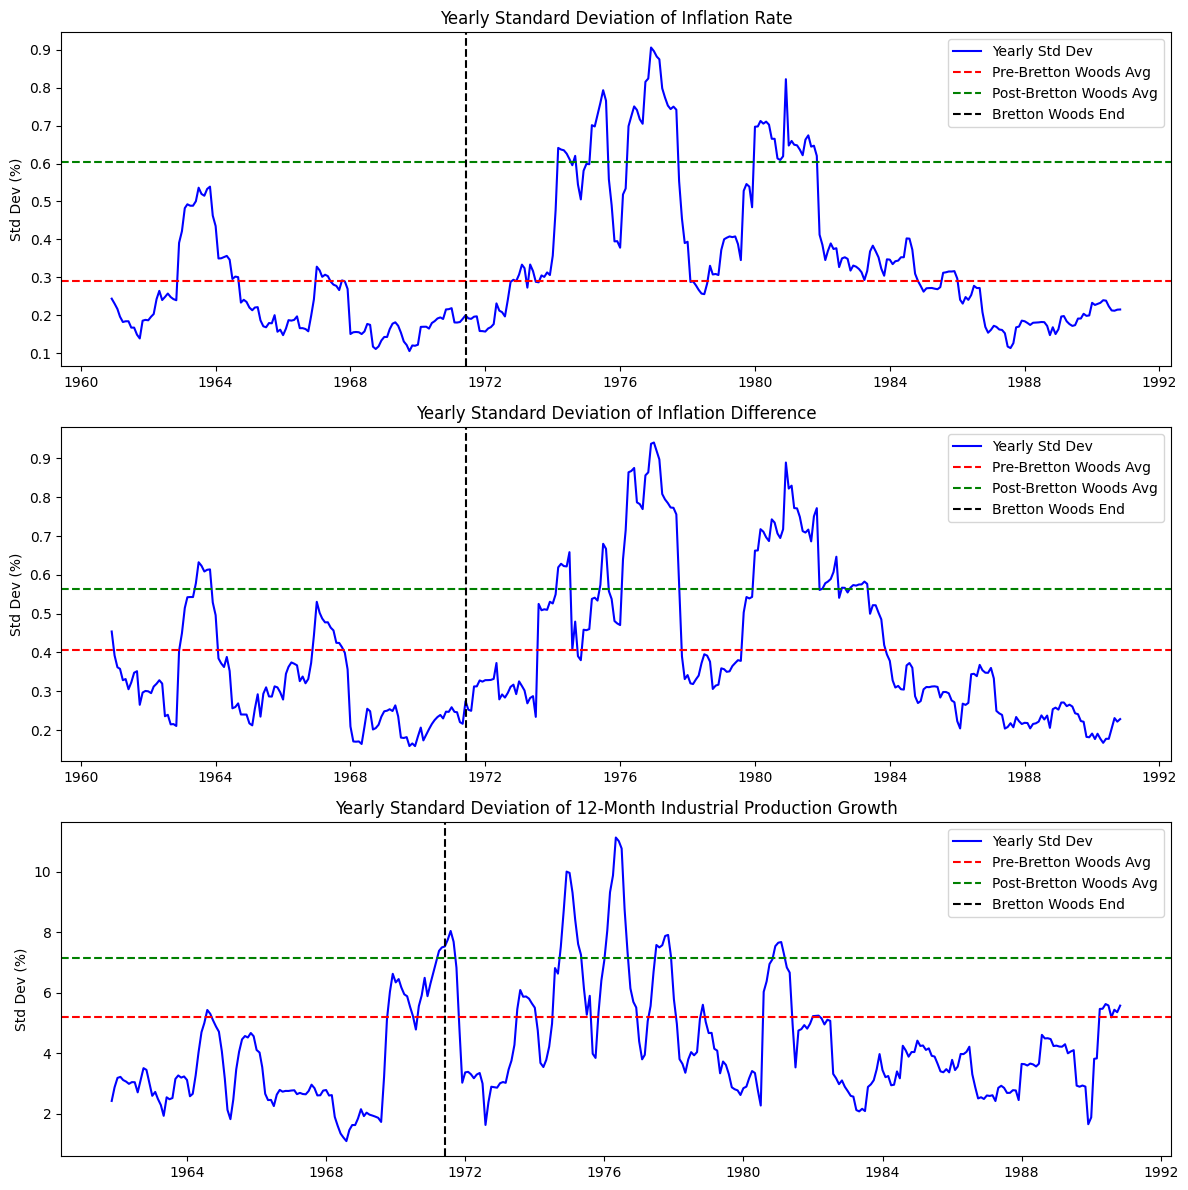

Regression: Inflation Difference vs Real Exchange Rate Std Dev
                              OLS Regression Results                             
Dep. Variable:     6M_Inflation_Diff_Std   R-squared:                       0.090
Model:                               OLS   Adj. R-squared:                  0.087
Method:                    Least Squares   F-statistic:                     34.79
Date:                   Thu, 20 Mar 2025   Prob (F-statistic):           8.58e-09
Time:                           23:31:18   Log-Likelihood:                 71.340
No. Observations:                    355   AIC:                            -138.7
Df Residuals:                        353   BIC:                            -130.9
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

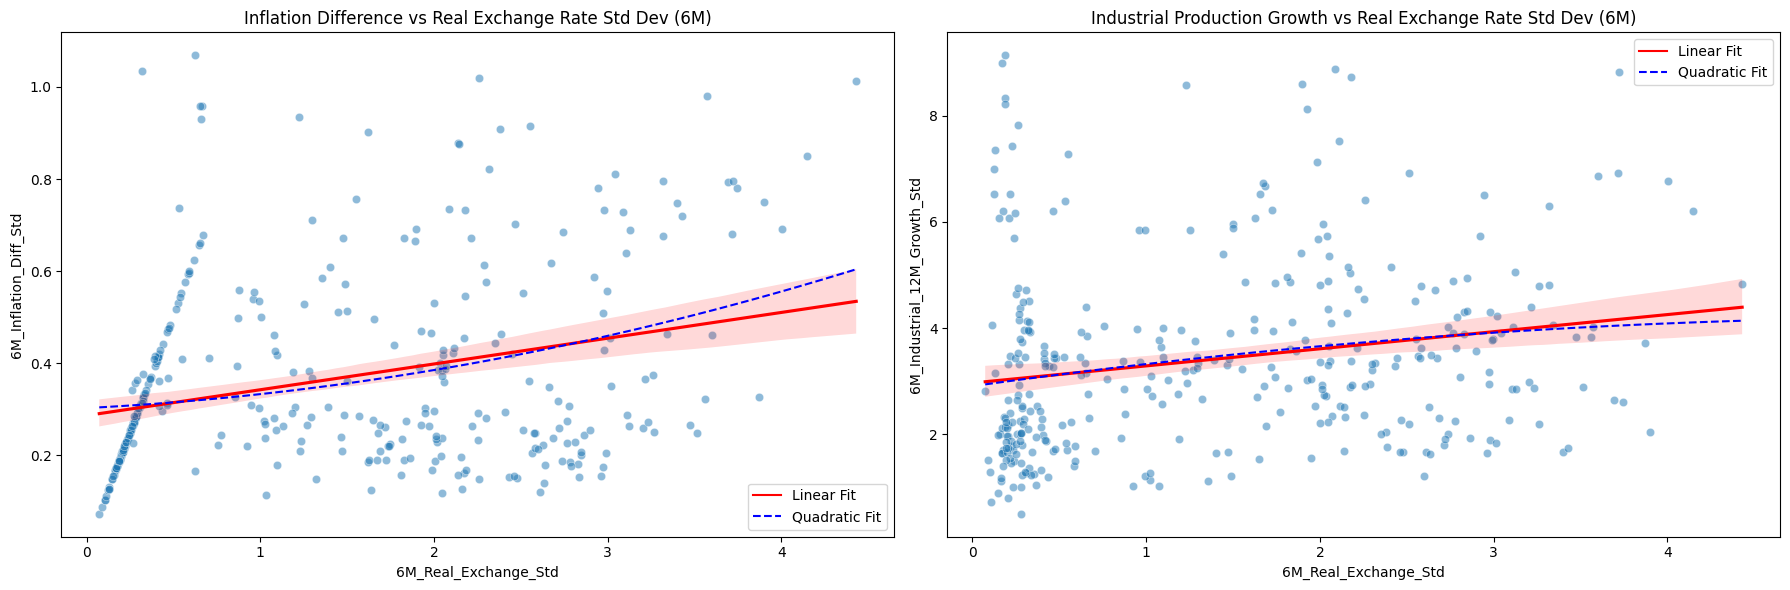

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Load the Excel file
file_path = "Final_OneSheet_Cleaned.xlsx"
df = pd.read_excel(file_path)

# Convert date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Defining the Bretton Woods periods as given in the instructions document
pre_bretton_woods_end = '1971-06'  # Bretton Woods ends
post_bretton_woods_start = '1973-03'  # Post-Bretton Woods starts
bretton_woods_end_date = pd.Timestamp(pre_bretton_woods_end)
pre_bretton_woods_end = pd.to_datetime(pre_bretton_woods_end, format='%Y-%m')

###############################################################################
#  5.2.1 Exchange Rate and International Reserve Graphs
###############################################################################

# Compute monthly growth in nominal exchange rate, real exchange rate and real exchange rate growth
df['Nominal_Exchange_Growth'] = df['Exchange Rate'].pct_change() * 100
df['Real_Exchange_Rate'] = df['Exchange Rate'] * (df['US Consumer Prices'] / df['Consumer Prices'])
df['Real_Exchange_Growth'] = df['Real_Exchange_Rate'].pct_change() * 100

# Index international reserves
df['Reserves_Index'] = df['International Reserves'] / df['International Reserves'].iloc[0] * 100
df['US_Reserves_Index'] = df['US International Reserves'] / df['US International Reserves'].iloc[0] * 100

# Here we use a combined graph with 2 Y axis to show both growth rate and index values for exchange rates in the same graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y-Axis: Index Values (Exchange Rates)
line1, = ax1.plot(df.index, df['Exchange Rate'], color='blue', label='Nominal Exchange Rate (vs. USD)')
line2, = ax1.plot(df.index, df['Real_Exchange_Rate'], color='green', label='Real Exchange Rate Index (vs. USD)')
ax1.set_ylabel('Index Value', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Right Y-Axis: Growth Rates
ax2 = ax1.twinx()
line3, = ax2.plot(df.index, df['Nominal_Exchange_Growth'], color='red', label='Nominal Exchange Growth')
line4, = ax2.plot(df.index, df['Real_Exchange_Growth'], color='orange', label='Real Exchange Growth')
ax2.set_ylabel('Growth Rate (%)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add vertical dotted line to show when the Bretton Woods exit was
ax1.axvline(pre_bretton_woods_end, linestyle="--", color="black", label="Bretton Woods End")

# Combine legends
lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10, frameon=False)

# Title and layout
plt.title('Exchange Rate Levels and Growth Rates')
plt.tight_layout()
plt.show()

# Graph: International Reserves (Indexed)
plt.figure(figsize=(12, 6))
plt.plot(df.loc[:pre_bretton_woods_end, 'Reserves_Index'], label="Italy's Reserves Index", color='blue')
plt.plot(df.loc[:pre_bretton_woods_end, 'US_Reserves_Index'], label="US Reserves Index", color='red')

# Adding Labels, legend, and vertical line
plt.axvline(pre_bretton_woods_end, linestyle="--", color="black", label="Bretton Woods End")
plt.ylabel('Index (Base Year = 100)')
plt.title('Indexed International Reserves (Until Bretton Woods Exit)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

###############################################################################
#  5.2.2 Inflation and Industrial Production Graphs
###############################################################################

# Compute inflation difference and scale by 100 for %
df['Inflation_Difference'] = (df['inflation_rate'] - df['us_inflation_rate']) * 100
df['inflation_rate'] = df['inflation_rate'] * 100

# Plot inflation graphs
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['inflation_rate'], label='Italy Inflation Rate', color='blue')
plt.plot(df.index, df['Inflation_Difference'], label='Inflation Rate Difference (vs. US)', color='red')
plt.axvline(pre_bretton_woods_end, linestyle="--", color="black", label="Bretton Woods End")

# Labels and legend
plt.ylabel('Inflation Rate (%)')
plt.title('Inflation Trends')
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Multiply industrial production rates by 100
df['industrial_production_growth'] *= 100
df['industrial_production_12m_growth'] *= 100

# Plot industrial production growth
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['industrial_production_growth'], label='Industrial Production Growth (Monthly)', color='green')
plt.plot(df.index, df['industrial_production_12m_growth'], label='Industrial Production Growth (12 Month Difference)', color='orange')
plt.axvline(pre_bretton_woods_end, linestyle="--", color="black", label="Bretton Woods End")


# Labels and legend
plt.ylabel('Growth Rate (%)')
plt.title('Industrial Production Growth')
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

###############################################################################
#  5.2.3 Comparison of Standard Deviations
###############################################################################

# Split data into pre- and post-Bretton Woods periods
df_pre = df[:pre_bretton_woods_end]
df_post = df[post_bretton_woods_start:]

# Compute standard deviations for key metrics
std_pre = df_pre[['Nominal_Exchange_Growth', 'Real_Exchange_Growth', 'inflation_rate', 
                  'Inflation_Difference', 'industrial_production_12m_growth']].std()
std_post = df_post[['Nominal_Exchange_Growth', 'Real_Exchange_Growth', 'inflation_rate', 
                   'Inflation_Difference', 'industrial_production_12m_growth']].std()

# Compute the ratio of standard deviations
std_ratio = std_post / std_pre

# Create DataFrame for standard deviation comparison
std_comparison = pd.DataFrame({
    'Pre-Bretton Woods': std_pre,
    'Post-Bretton Woods': std_post,
    'Ratio (Post:Pre)': std_ratio
}).round(2)

# Display table
print("Standard Deviations Before and After Bretton Woods")
display(std_comparison)  # Ensures proper display in Jupyter Notebook

# Compute rolling 12-month standard deviation
rolling_std = df[['inflation_rate', 'Inflation_Difference', 'industrial_production_12m_growth']].rolling(window=12).std()

# Set up figure
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot Inflation Rate Standard Deviation
axes[0].plot(rolling_std.index, rolling_std['inflation_rate'], label='Yearly Std Dev', color='blue')
axes[0].axhline(std_pre['inflation_rate'], linestyle='--', color='red', label='Pre-Bretton Woods Avg')
axes[0].axhline(std_post['inflation_rate'], linestyle='--', color='green', label='Post-Bretton Woods Avg')
axes[0].axvline(pre_bretton_woods_end, linestyle="--", color="black", label="Bretton Woods End")  # Move inside subplot
axes[0].set_title('Yearly Standard Deviation of Inflation Rate')
axes[0].set_ylabel('Std Dev (%)')
axes[0].legend()

# Plot Inflation Difference Standard Deviation
axes[1].plot(rolling_std.index, rolling_std['Inflation_Difference'], label='Yearly Std Dev', color='blue')
axes[1].axhline(std_pre['Inflation_Difference'], linestyle='--', color='red', label='Pre-Bretton Woods Avg')
axes[1].axhline(std_post['Inflation_Difference'], linestyle='--', color='green', label='Post-Bretton Woods Avg')
axes[1].axvline(pre_bretton_woods_end, linestyle="--", color="black", label="Bretton Woods End")  # Move inside subplot
axes[1].set_title('Yearly Standard Deviation of Inflation Difference')
axes[1].set_ylabel('Std Dev (%)')
axes[1].legend()

# Plot 12-Month Industrial Production Growth Standard Deviation
axes[2].plot(rolling_std.index, rolling_std['industrial_production_12m_growth'], label='Yearly Std Dev', color='blue')
axes[2].axhline(std_pre['industrial_production_12m_growth'], linestyle='--', color='red', label='Pre-Bretton Woods Avg')
axes[2].axhline(std_post['industrial_production_12m_growth'], linestyle='--', color='green', label='Post-Bretton Woods Avg')
axes[2].axvline(pre_bretton_woods_end, linestyle="--", color="black", label="Bretton Woods End")  # Move inside subplot
axes[2].set_title('Yearly Standard Deviation of 12-Month Industrial Production Growth')
axes[2].set_ylabel('Std Dev (%)')
axes[2].legend()

plt.tight_layout()
plt.show()


###############################################################################
# 5.2.4 Regression Analysis
###############################################################################

# Compute rolling 6-month standard deviations
df['6M_Real_Exchange_Std'] = df['Real_Exchange_Growth'].rolling(6).std()
df['6M_Inflation_Diff_Std'] = df['Inflation_Difference'].rolling(6).std()
df['6M_Industrial_12M_Growth_Std'] = df['industrial_production_12m_growth'].rolling(6).std()

# Drop NaN values for regression
df_reg = df.dropna()

### Run Linear Regressions ###
# Independent Variable
X = df_reg['6M_Real_Exchange_Std']
X = sm.add_constant(X)  # Add constant term for intercept

# Regression 1: Inflation Difference vs Real Exchange Rate Std Dev
y1 = df_reg['6M_Inflation_Diff_Std']
model1 = sm.OLS(y1, X).fit()

# Regression 2: Industrial Production Growth vs Real Exchange Rate Std Dev
y2 = df_reg['6M_Industrial_12M_Growth_Std']
model2 = sm.OLS(y2, X).fit()

# Print regression summaries
print("Regression: Inflation Difference vs Real Exchange Rate Std Dev")
print(model1.summary())

print("\nRegression: Industrial Production Growth vs Real Exchange Rate Std Dev")
print(model2.summary())

# Set up figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Function to plot scatter plots with linear & quadratic best-fit lines
def plot_regression(ax, x, y, title):
    # Scatter plot
    sns.scatterplot(x=x, y=y, ax=ax, alpha=0.5)

    # Linear regression line (without automatic legend)
    sns.regplot(x=x, y=y, ax=ax, scatter=False, line_kws={'color': 'red'})  
    ax.plot([], [], label="Linear Fit", color="red")  # Manually add to legend

    # Quadratic regression line
    x_vals = np.linspace(x.min(), x.max(), 100)
    poly_coeffs = np.polyfit(x, y, 2)  # Get quadratic coefficients
    y_poly = np.polyval(poly_coeffs, x_vals)  # Compute quadratic values
    ax.plot(x_vals, y_poly, color='blue', linestyle='--', label='Quadratic Fit')

    # Labels and title
    ax.set_title(title)
    ax.legend()

# Plot 1: Inflation Difference vs Real Exchange Rate Std Dev
plot_regression(axes[0], df_reg['6M_Real_Exchange_Std'], df_reg['6M_Inflation_Diff_Std'], 
                "Inflation Difference vs Real Exchange Rate Std Dev (6M)")

# Plot 2: Industrial Production Growth vs Real Exchange Rate Std Dev
plot_regression(axes[1], df_reg['6M_Real_Exchange_Std'], df_reg['6M_Industrial_12M_Growth_Std'], 
                "Industrial Production Growth vs Real Exchange Rate Std Dev (6M)")

plt.tight_layout()
plt.show()